### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from astroML.utils import split_samples, completeness_contamination
import corner
import warnings
warnings.simplefilter('ignore')

function to compute the selected model

In [2]:
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        #print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

function to plot the roc curve for each selected model

In [13]:
def plot_roc(y_t):
    names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression, {}),
                              (KNeighborsClassifier,
                               {}),
                              (DecisionTreeClassifier,
                               {}),
                              (GMMBayes, {}),
                                 (RandomForestClassifier, {}))
    
    labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR',
               RandomForestClassifier = 'RFC')
  
    fig = plt.figure(figsize=(15, 5))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
    ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
    ax2 = plt.subplot(132)

# ax3 will show precision/recall
# ax3 = plt.subplot(133)

    thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
    for name, y_prob in zip(names, probs):
        fpr, tpr, thresh = roc_curve(y_t, y_prob)
        precision, recall, thresh2 = precision_recall_curve(y_t, y_prob)

        # add (0, 0) as first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
        # Here we add (1,0) 
        precision = np.concatenate([[0], precision])
        recall = np.concatenate([[1], recall])
        thresh2 = np.concatenate([[0], thresh2])

        ax1.plot(fpr, tpr, label=labels[name])
    
        #See note above about astroML vs. sklearn
        #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
        comp = np.zeros_like(thresholds)
        cont = np.zeros_like(thresholds)
        for i, t in enumerate(thresholds):
            y_pred = (y_prob >= t)
            comp[i], cont[i] = completeness_contamination(y_pred, y_t)
        ax2.plot(1 - cont, comp, label=labels[name])
    
    ax1.set_xlim(0, 0.04)
    ax1.set_ylim(0.7, 1.02)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.set_xlabel('false positive rate')
    ax1.set_ylabel('true positive rate')
    ax1.legend(loc=4)
    
    ax2.set_xlabel('efficiency')
    ax2.set_ylabel('completeness')
    ax2.set_xlim(0, 1.0)
    ax2.set_ylim(0.7, 1.02)
    
    plt.show()

In [4]:
df = pd.read_csv("../solutions/galaxyquasar.csv")
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


Creating columns with colours from the columns with the different magnitudes

In [5]:
df['u-g'] = df['u']- df['g'] 
df['g-r'] = df['g']- df['r'] 
df['r-i'] = df['r']- df['i']
df['i-z'] = df['i']- df['z']

Substituting the classes "QSO" and "galaxy" with binary digits "1" and "0"

In [6]:
le = LabelEncoder()
# Assign unique integers: 1 QSO, 0 galaxy
df['class'] = le.fit_transform(df['class'] )
labels_class = le.inverse_transform(df['class'] )
class_names = le.classes_
print('Class names: ', class_names)
print('Labels: ', labels_class)

Class names:  ['GALAXY' 'QSO']
Labels:  ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


### 1. Computing the ROC curves selecting different number of features

#### 1.0: 1 feature

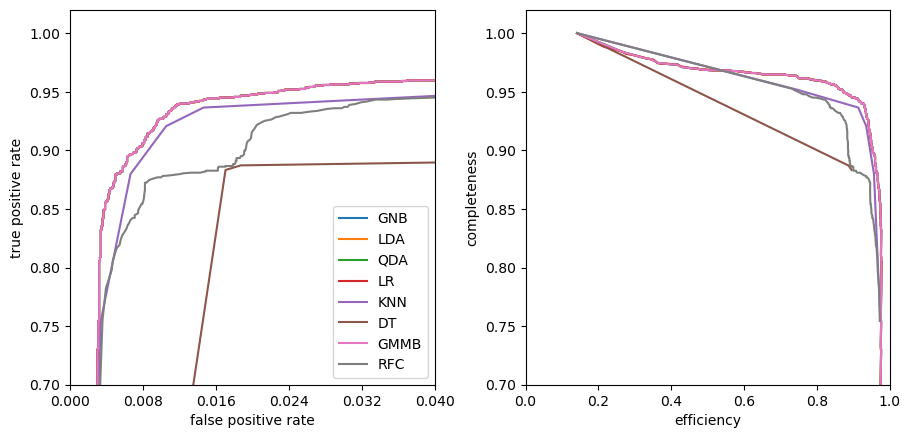

In [14]:
(X_train, X_test), (y_train, y_test) = split_samples( np.array(df['u-g'])[:, np.newaxis], df['class'], [0.75, 0.25], random_state=0)
plot_roc(y_test)

#### 1.1: 2 features

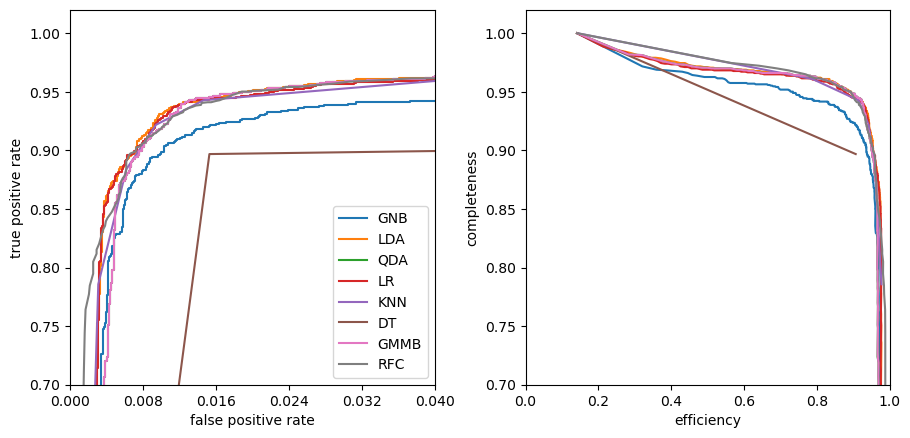

In [27]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'g-r'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

#### 1.2: 3 features

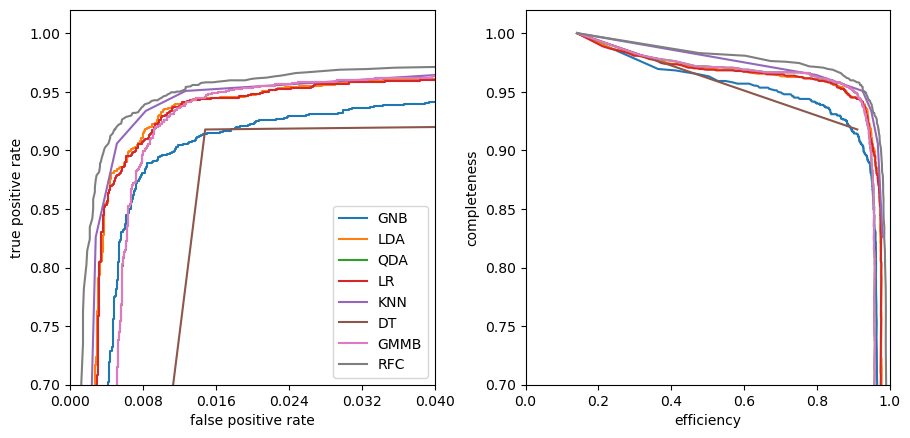

In [28]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'r-i'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

#### 1.3: 4 features

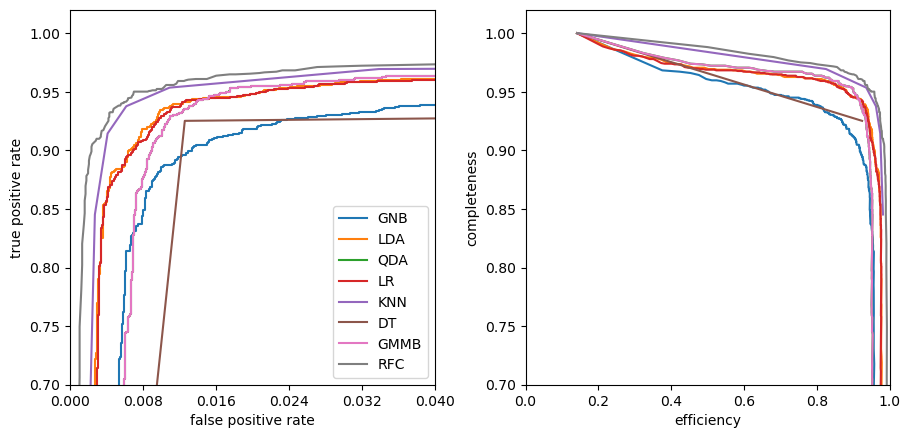

In [29]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'i-z'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

### 2 Visualizing the features

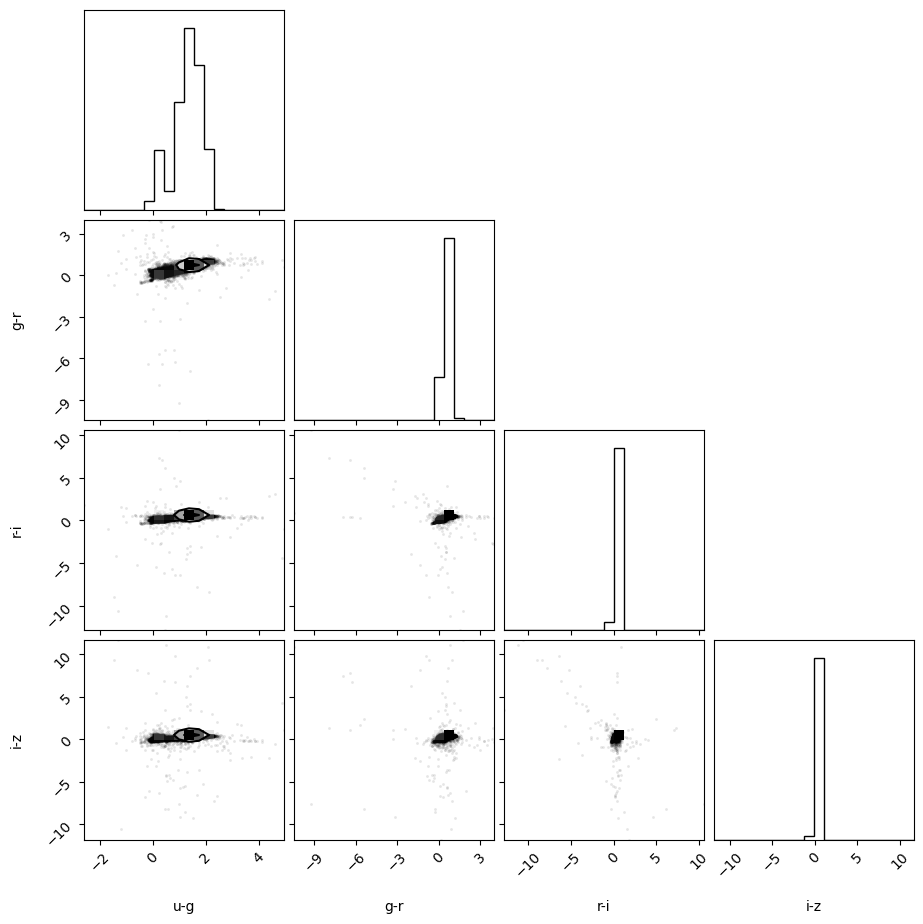

In [11]:
corner.corner((df.loc[:, 'u-g':'i-z']), labels=['u-g', 'g-r', 'r-i', 'i-z']);

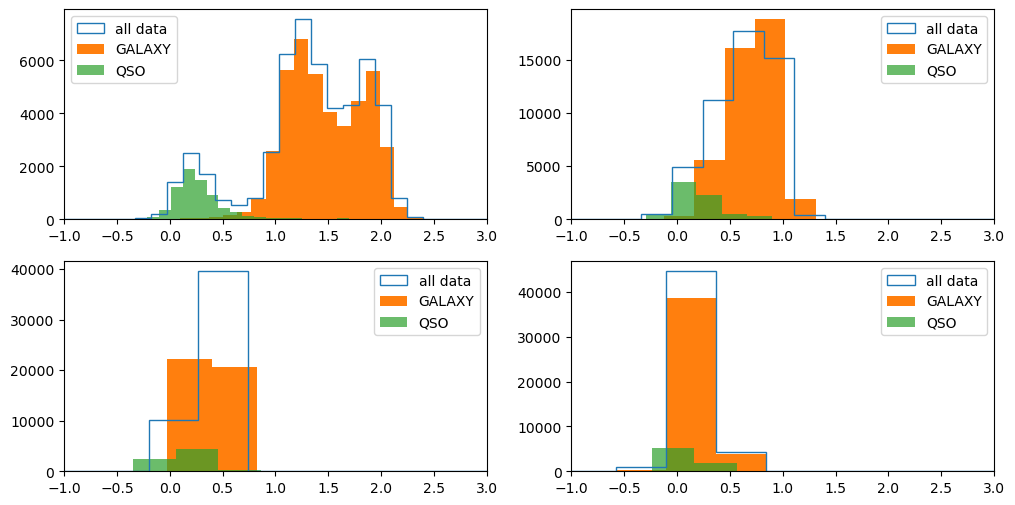

In [26]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(221)
ax1.hist(df.loc[:, 'u-g'], bins = 50, histtype = 'step', label = 'all data')
ax1.hist(df.loc[:, 'u-g'][labels_class=='GALAXY'], bins = 50, label = 'GALAXY')
ax1.hist(df.loc[:, 'u-g'][labels_class=='QSO'], bins = 50, alpha = 0.7, label = 'QSO')
ax1.set_xlim(-1,3)
ax1.legend();

ax2 = fig.add_subplot(222)
ax2.hist(df.loc[:, 'g-r'], bins = 50, histtype = 'step', label = 'all data')
ax2.hist(df.loc[:, 'g-r'][labels_class=='GALAXY'], bins = 50, label = 'GALAXY')
ax2.hist(df.loc[:, 'g-r'][labels_class=='QSO'], bins = 50, alpha = 0.7, label = 'QSO')
ax2.set_xlim(-1,3)
ax2.legend();

ax3 = fig.add_subplot(223)
ax3.hist(df.loc[:, 'r-i'], bins = 50, histtype = 'step', label = 'all data')
ax3.hist(df.loc[:, 'r-i'][labels_class=='GALAXY'], bins = 50, label = 'GALAXY')
ax3.hist(df.loc[:, 'r-i'][labels_class=='QSO'], bins = 50, alpha = 0.7, label = 'QSO')
ax3.set_xlim(-1,3)
ax3.legend();

ax4 = fig.add_subplot(224)
ax4.hist(df.loc[:, 'i-z'], bins = 50, histtype = 'step', label = 'all data')
ax4.hist(df.loc[:, 'i-z'][labels_class=='GALAXY'], bins = 50, label = 'GALAXY')
ax4.hist(df.loc[:, 'i-z'][labels_class=='QSO'], bins = 50, alpha = 0.7, label = 'QSO')
ax4.set_xlim(-1,3)
ax4.legend();

As it can be seen from the histogram plots, it seems that the galaxy and the quasars present different distributions in the colors. This is accentuated by the color "u-g", which clearly presents a bimodal distribution.

### 3. Comparing ROC curves for different number of features

We can visualize how the number of features included in the model can affect their performances.

In [31]:
names = [
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GMMBayes(),
    RandomForestClassifier()
]


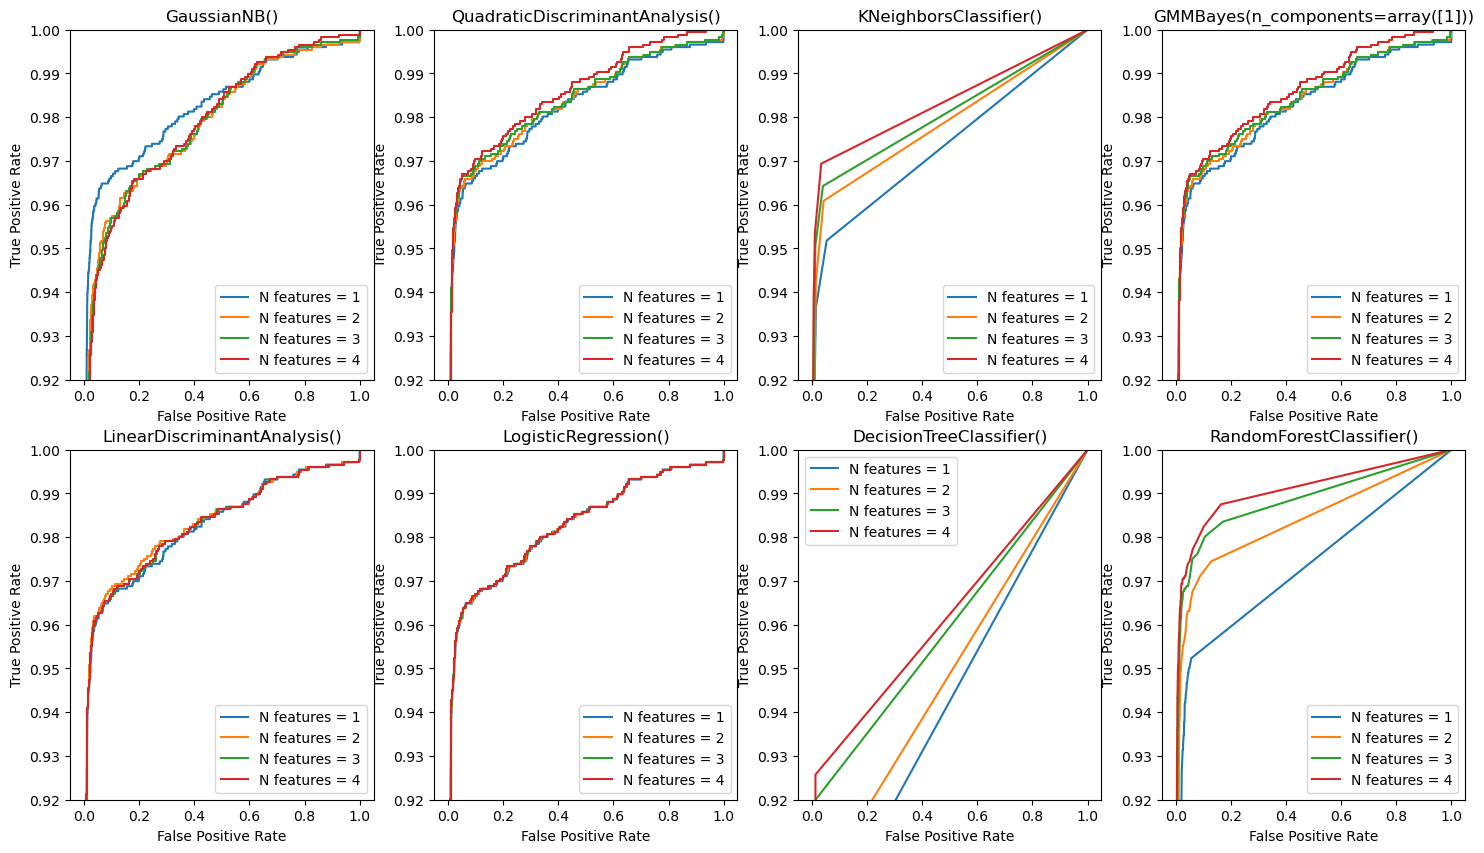

In [35]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'i-z'], df['class'], [0.75, 0.25], random_state=0)

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
for idx, clf in enumerate(names):
    fpr = []
    tpr = []
    thresh = []
    for i in range(4):
        clf.fit(X_train[:, 0:i+1], y_train)
        y_prob = clf.predict_proba(X_test[:,0:i+1])[:,1]     
        fpr.append(roc_curve(y_test, y_prob)[0])
        tpr.append(roc_curve(y_test, y_prob)[1])
        thresh.append(roc_curve(y_test, y_prob)[2])    
    axes[int(idx%2)][int(np.floor(idx/2))].plot(fpr[0], tpr[0], label='N features = 1')
    axes[int(idx%2)][int(np.floor(idx/2))].plot(fpr[1], tpr[1], label='N features = 2')
    axes[int(idx%2)][int(np.floor(idx/2))].plot(fpr[2], tpr[2], label='N features = 3')
    axes[int(idx%2)][int(np.floor(idx/2))].plot(fpr[3], tpr[3], label='N features = 4')
    axes[int(idx%2)][int(np.floor(idx/2))].legend()
    axes[int(idx%2)][int(np.floor(idx/2))].set_title(str(clf))
    axes[int(idx%2)][int(np.floor(idx/2))].set_ylim(0.92, 1)
    axes[int(idx%2)][int(np.floor(idx/2))].set_xlabel('False Positive Rate')    
    axes[int(idx%2)][int(np.floor(idx/2))].set_ylabel('True Positive Rate')
plt.show()

In most cases, the increment of the number of features improves the results of the model. However, we can also notice that for the GaussianNB() model the best performance was obtained with just the feature of the color "u-g". Also, the LogisticRegression is not impacted by an increase of the features.